# XGBoost (eXtreme Gradient Boosting)

- É uma implementação avançada do algoritmo de ‘boosting’ de gradiente. A sua funcionalidade de implementar computação paralela o torna pelo menos 10 vezes mais rápido do que outras implementações de ‘boosting’ de gradiente. Suporta várias funções objetivas, incluindo regressão, classificação e ranqueamento.

- Fonte [Visualize a Decision Tree in 4 Ways with Scikit-Learn and Python](https://mljar.com/blog/visualize-decision-tree/)
- Fonte [Let’s Solve Overfitting! Quick Guide to Cost Complexity Pruning of Decision Trees](https://www.analyticsvidhya.com/blog/2020/10/cost-complexity-pruning-decision-trees/)
- Fonte [Um tutorial completo sobre modelagem baseada em árvores de decisão (códigos R e Python)](https://www.vooo.pro/insights/um-tutorial-completo-sobre-a-modelagem-baseada-em-tree-arvore-do-zero-em-r-python/)

## Carregando Biblioteca

In [69]:
import pandas as pd
import numpy as np
#Visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt
#Pré-processamento
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale
#Dados de Treino
from sklearn import datasets
from sklearn.model_selection import train_test_split
#Árvore Randômica
import xgboost as xgb
from xgboost.sklearn import XGBClassifier, XGBRegressor
#Metricas
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

## Carregando os dados

In [4]:
df = pd.read_csv("../datasets/titanic/train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Pré-Processamento de Dados

In [5]:
def pronomes(x):
    if 'Mr' in x:
        return 'Mr'
    elif 'Don' in x:
        return 'Mr'
    elif 'Mrs' in x:
        return 'Mrs'
    elif 'Ms' in x:
        return 'Mrs'
    elif 'Mme' in x:
        return 'Mrs'
    elif 'Miss' in x:
        return 'Miss'
    elif 'Mlle' in x:
        return 'Miss'
    elif 'Dr' in x:
        return 'Dr'
    elif 'Rev' in x:
        return 'Rev'
    elif 'Master' in x:
        return 'Master'
    elif 'Major' in x:
        return 'Major'
    elif 'Capt' in x:
        return 'Capt'
    elif 'Jonkheer' in x:
        return 'Mr'
    elif 'Col' in x:
        return 'Col'
    elif 'Countess' in x:
        return 'Mrs'
    else:
        return 'None'
# Extração de Pronomes
df['Name'] = df['Name'].apply(pronomes)

# Categóricas para Numéricas
le_name = LabelEncoder()
df['Name']  = le_name.fit_transform(df['Name'])

# Substituir valores ausentes/nulos
df['Age'].fillna(df['Age'].mean(), inplace = True)
df.loc[df['Embarked'].isna(), ['Embarked']] = df['Embarked'].value_counts().index[0]

# Categórico Para numérico
le_sex = LabelEncoder()
df['Sex']  = le_sex.fit_transform(df['Sex'])
le_embarked = LabelEncoder()
df['Embarked'] = le_embarked.fit_transform(df['Embarked'])

# Remoção de colunas
df = df.drop(columns=['PassengerId', 'Ticket', 'Cabin'])

#Escalonamento 
df[['Age', 'Fare']] = pd.DataFrame( scale(df[['Age', 'Fare']]),
                                    index = df.index,
                                    columns = ['Age', 'Fare'])

df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,6,1,-0.592481,1,0,-0.502445,2
1,1,1,6,0,0.638789,1,0,0.786845,0
2,1,3,5,0,-0.284663,0,0,-0.488854,2
3,1,1,6,0,0.407926,1,0,0.420730,2
4,0,3,6,1,0.407926,0,0,-0.486337,2


## Dados de Treino e Teste

In [6]:
x = df.drop(columns='Survived')
y = df['Survived']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# XGBClassifier

- **booster** [default = gbtree] - Seleciona o tipo de modelo a ser executado em cada iteração. Possui 2 opções:
    - gbtree: modelos baseados em árvore
    - gblinear: modelos lineares
- **silent** [padrão = 0] - O modo silencioso ativado é definido como 1, ou seja, nenhuma mensagem em execução será impressa. Geralmente é bom mantê-lo em 0, pois as mensagens podem ajudar na compreensão do modelo.
- **nthread** [padrão para o número máximo de threads disponíveis se não for definido] - Isso é usado para processamento paralelo e o número de núcleos no sistema deve ser inserido. Se você deseja executar em todos os núcleos, o valor não deve ser inserido e o algoritmo detectará automaticamente
- **eta** [padrão = 0,3] - Torna o modelo mais robusto, reduzindo os pesos em cada etapa. Valores finais típicos a serem usados: 0,01-0,2
-  **min_child_weight** [default = 1] - Define a soma mínima dos pesos de todas as observações exigidas em uma criança. Isso se refere à “soma dos pesos” mínimas das observações. Usado para controlar o sobreajuste. Valores mais altos evitam que um modelo aprenda relações que podem ser altamente específicas para a amostra particular selecionada para uma árvore. Valores muito altos podem levar a um ajuste insuficiente, portanto, ele deve ser ajustado usando CV.
- **max_depth** [default = 6] - A profundidade máxima de uma árvore. Usado para controlar o sobreajuste, uma vez que uma profundidade maior permitirá que o modelo aprenda relações muito específicas para uma amostra particular.  Deve ser ajustado usando CV. Valores típicos: 3-10
- **max_leaf_nodes** -  O número máximo de nós terminais ou folhas em uma árvore. Pode ser definido no lugar de max_depth. Uma vez que árvores binárias são criadas, uma profundidade de 'n' produziria um máximo de $2^n$ folhas. Se estiver definido, o GBM irá ignorar max_depth.
- **gama** [padrão = 0] - Um nó é dividido apenas quando a divisão resultante dá uma redução positiva na função de perda. Gama especifica a redução de perda mínima necessária para fazer uma divisão. Torna o algoritmo conservador. Os valores podem variar dependendo da função de perda e devem ser ajustados.
- **max_delta_step** [default = 0] - Na etapa delta máxima, permitimos que a estimativa de peso de cada árvore seja. Se o valor for definido como 0, significa que não há restrição. Se for definido com um valor positivo, pode ajudar a tornar a etapa de atualização mais conservadora. Normalmente este parâmetro não é necessário, mas pode ajudar na regressão logística quando a classe está extremamente desequilibrada. Isso geralmente não é usado, mas você pode explorar mais se desejar.
- **subsample** [padrão = 1] - Denota a fração de observações a serem amostras aleatoriamente para cada árvore.  Valores mais baixos tornam o algoritmo mais conservador e evita o sobreajuste, mas valores muito pequenos podem levar ao subajuste. Valores típicos: 0,5-1
- **colsample_bytree** [default = 1] - Semelhante a max_features em GBM. Denota a fração de colunas a serem amostras aleatoriamente para cada árvore. Valores típicos: 0,5-1
- **colsample_bylevel** [default = 1] - Denota a proporção da subamostra de colunas para cada divisão, em cada nível. Eu não uso isso com frequência porque subsample e colsample_bytree farão o trabalho para você. mas você pode explorar mais se achar que sim.
- **lambda [padrão = 1]** - Termo de regularização L2 em pesos (análogo à regressão de Ridge). Isso costumava lidar com a parte de regularização do XGBoost. Embora muitos cientistas de dados não o usem com frequência, ele deve ser explorado para reduzir o sobreajuste.
- **alpha** [padrão = 0] -  Termo de regularização L1 em peso (análogo à regressão Lasso). Pode ser usado em caso de dimensionalidade muito alta para que o algoritmo rode mais rápido quando implementado
- **scale_pos_weight** [default = 1] -  m valor maior que 0 deve ser usado em caso de desequilíbrio de classe alto, pois ajuda na convergência mais rápida.
- **objective** - [padrão = reg: linear] -  Isso define a função de perda a ser minimizada. Os valores mais usados são:
    - binário: regressão logística - logística para classificação binária, retorna probabilidade prevista (não classe)
    - multi: softmax - classificação multiclasse usando a objetiva softmax, retorna a classe prevista (não probabilidades)
        - você também precisa definir um parâmetro adicional num_class (número de classes) definindo o número de classes únicas
    - multi: softprob –same como softmax, mas retorna a probabilidade prevista de cada ponto de dados pertencente a cada classe.
- **eval_metric** [padrão de acordo com o objetivo] -  A métrica a ser usada para dados de validação. Os valores padrão são rmse para regressão e erro para classificação. Os valores típicos são:
    - rmse - raiz quadrada média do erro
    - mae - erro absoluto médio
    - logloss - log-verossimilhança negativa
    - erro - Taxa de erro de classificação binária (limite de 0,5)
    - merror - Taxa de erro de classificação multiclasse
    - mlogloss - Logloss multiclasse
    - auc: Área sob a curva
- **seed** [padrão = 0] - A semente do número aleatório. Pode ser usado para gerar resultados reproduzíveis e também para ajuste de parâmetros. 
- O metodo **fit()** é usado para treinar o modelo
- O método **predict()** é usado para prever um dado

In [23]:
classificador = XGBClassifier(use_label_encoder=False)

classificador = classificador.fit(x_train, y_train)

[01:04:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


## Prever um valor

In [24]:
data = {
    'Pclass': [1],
    'Name': ['Miss'],
    'Sex': ['female'],
    'Age': [5],
    'SibSp': [1],
    'Parch': [1],
    'Fare': [50],
    'Embarked': ['C']
}

#Transformando do Dicionário em DataFrame
data = pd.DataFrame(data)

#Tratando os Dados
# Categóricas para Numéricas

data['Name']  = le_name.transform(data['Name'])
data['Sex']  = le_sex.transform(data['Sex'])
data['Embarked'] = le_embarked.transform(data['Embarked'])
data[['Age', 'Fare']] = pd.DataFrame( scale(data[['Age', 'Fare']]),
                                    index = data.index,
                                    columns = ['Age', 'Fare'])

#Classificando
previsao = classificador.predict(data)
print("\nPrevendo o dataframe criado: ", previsao)


Prevendo o dataframe criado:  [1]


## Prever os dados de Teste

In [25]:
previsao = classificador.predict(x_test)

acuracia = 100 * np.sum(previsao == y_test)/ len(y_test)

print("Acurácia {}%".format(acuracia))

Acurácia 84.35754189944134%


# Matriz de Confusão

- A biblioteca **sklearn.metrics** tem a função **confusion_matrix** que irá nos retornar a matriz de confusão dos dados previstos. 
- **y_true** - Valores alvo verdadeiros (corretos). 
- **y_pred** - Alvos estimados conforme retornados por um classificador. 
- **labels** - Lista de rótulos para indexar a matriz. Isso pode ser usado para reordenar ou selecionar um subconjunto de rótulos. Se Nenhum for fornecido, aqueles que aparecem pelo menos uma vez em y_true ou y_pred são usados na ordem de classificação 
- **sample_weight** - Pesos de amostra. 
- **normalize**: {‘true’, ‘pred’, ‘all’}, default=None - Normaliza a matriz de confusão sobre as condições verdadeiras (linhas), preditas (colunas) ou toda a população. Se nenhum, a matriz de confusão não será normalizada. 

In [26]:
confusion_matrix(y_test, previsao)

array([[100,  10],
       [ 18,  51]], dtype=int64)

## Personalizando a matriz de confusão

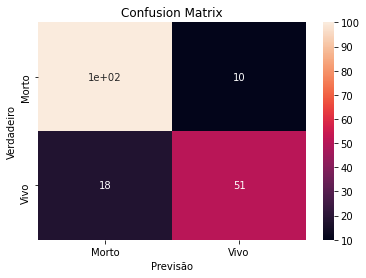

In [27]:
cm = confusion_matrix(y_test, previsao)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Previsão');
ax.set_ylabel('Verdadeiro'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Morto', 'Vivo']);
ax.yaxis.set_ticklabels(['Morto', 'Vivo']);

## Métricas

- A biblioteca **sklearn.metrics** tem a função **classification_report** que cria um relatório de texto mostrando as principais métricas de classificação. 
- **y_true** - Valores alvo verdadeiros (corretos). 
- **y_pred** - Alvos estimados conforme retornados por um classificador. 
- **labels** - Lista opcional de índices de rótulo a serem incluídos no relatório. 
- **target_names** - Nomes de exibição opcionais que correspondem aos rótulos (mesma ordem) 
- **sample_weight** - Peso das Amostras
- **digits** - Número de dígitos para formatar valores de ponto flutuante de saída. Quando output_dict for True, isso será ignorado e os valores retornados não serão arredondados.
- **output_dict** - Se verdadeiro, retorna a saída como dict
- **zero_division**: 'warn', 0 or 1, default='warn' - Define o valor a ser retornado quando houver uma divisão zero. Se definido como “aviso”, funciona como 0, mas os avisos também são gerados. 

In [28]:
print(classification_report(y_test, previsao, target_names = ['Morto', 'Vivo']))

              precision    recall  f1-score   support

       Morto       0.85      0.91      0.88       110
        Vivo       0.84      0.74      0.78        69

    accuracy                           0.84       179
   macro avg       0.84      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



## Acurácia

- A função **accuracy_score** pode ser usada para verificar a acurácia dos dados

In [29]:
accuracy_score(y_test, previsao)

0.8435754189944135

# Validação Cruzada

- A função **cross_val_score** realiza a validação cruzada.
- **estimator** - O objeto a ser usado para ajustar os dados (classificador).
- **X** - array-like of shape (n_samples, n_features) -   Os dados para caber. Pode ser, por exemplo, uma lista ou um array.
- **y** - array-like of shape (n_samples,) or (n_samples, n_outputs), default=None - A variável alvo a tentar prever no caso de aprendizagem supervisionada.
- **group** - array-like of shape (n_samples,), default = None -      Rótulos de grupo para as amostras usadas durante a divisão do conjunto de dados em conjunto de treinamento / teste. Usado apenas em conjunto com uma instância cv "Grupo" (por exemplo, GroupKFold).
- **scoring** - str ou callable, default = None - Um str (consulte a documentação de avaliação do modelo) ou um objeto / função que pode ser chamado de scorer com scorer de assinatura (estimador, X, y) que deve retornar apenas um único valor. Semelhante a cross_validate, mas apenas uma única métrica é permitida.  Se Nenhum, o marcador padrão do estimador (se disponível) é usado.
- **cv** - int, gerador de validação cruzada ou iterável, padrão = None -      Determina a estratégia de divisão de validação cruzada. As entradas possíveis para cv são:
    - Nenhum, para usar a validação cruzada de 5 vezes padrão,
    - int, para especificar o número de dobras em um KFold (estratificado),         - Divisor de CV,
    - Um rendimento iterável (treinar, testar) se divide como matrizes de índices.
    - Para entradas int / Nenhum, se o estimador for um classificador ey for binário ou multiclasse, StratifiedKFold é usado. Em todos os outros casos, o KFold é usado. Esses divisores são instanciados com shuffle = False para que as divisões sejam iguais nas chamadas.
    
- **n_jobs** - int, default = None - Número de trabalhos a serem executados em paralelo. O treinamento do estimador e o cálculo da pontuação são paralelizados nas divisões de validação cruzada. Nenhum significa 1, a menos que em um contexto joblib.parallel_backend. -1 significa usar todos os processadores. 
- **verbose** - int, default = 0 - O nível de verbosidade.
- **fit_params** - dict, default = None - Parâmetros para passar para o método de ajuste do estimador (classificador).
- **pre_dispatch** - int ou str, default = ’2 * n_jobs’ - Controla o número de trabalhos que são despachados durante a execução paralela. Reduzir esse número pode ser útil para evitar uma explosão de consumo de memória quando mais tarefas são despachadas do que as CPUs podem processar. Este parâmetro pode ser:
    - Nenhum, caso em que todos os empregos são imediatamente criados e reproduzidos. Use isso para trabalhos leves e de execução rápida, para evitar atrasos devido à geração sob demanda dos trabalhos
    - Um int, dando o número exato de empregos totais que são gerados
    -  Um str, dando uma expressão em função de n_jobs, como em ‘2 * n_jobs’
- **error_score** - raise ou numérico, default = np.nan -  Valor a ser atribuído à pontuação se ocorrer um erro no ajuste do estimador. Se definido como ‘aumentar’, o erro é gerado. Se um valor numérico for fornecido, FitFailedWarning é gerado 


In [30]:
x = df.drop(columns='Survived')
y = df['Survived']
scores = cross_val_score(classificador, x, y, cv = 5)

print("Acurracy: %0.2f (+\-) %0.2f " % (scores.mean(), scores.std() * 2))

[01:04:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:04:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:04:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:04:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

# Podar a Árvore

- Devemos pergar o menor erro possível para poder a árvore

max_depth = 5: deve estar entre 3-10. Comecei com 5, mas você também pode escolher um número diferente. 4-6 podem ser bons pontos de partida.

min_child_weight = 1: Um valor menor é escolhido porque é um problema de classe altamente desequilibrado e os nós folha podem ter grupos de tamanhos menores.

gama = 0: Um valor menor como 0,1-0,2 também pode ser escolhido para iniciar. De qualquer forma, isso será ajustado mais tarde.

subamostra, colsample_bytree = 0.8: Este é um valor inicial comumente usado. Os valores típicos variam entre 0,5-0,9.

scale_pos_weight = 1: Por causa do desequilíbrio de classe alta. 

In [68]:
classificador = XGBClassifier(use_label_encoder=False, max_depth=5, min_child_weight = 10, gamma = 0.1, colsample_bytree = 0.7,  subsample = 0.7, scale_pos_weight = 1)

#Rodar novamente
classificador = classificador.fit(x_train, y_train)

# CLASSIFICANDO
previsoes = classificador.predict(x_test)

# Accuracy
accuracy_score(y_test, previsoes)

[01:10:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8603351955307262

# Regressão

- Para fazer predições com regressão, use a função XGBRegressor

```Python
from xgboost.sklearn import XGBClassifier, XGBRegressor
```